In [1]:
# Célula 1: APENAS instalação
!pip install transformers datasets accelerate evaluate -U
print("--- Bibliotecas atualizadas ---")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 16.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompati

In [ ]:
# Célula 2: APENAS reiniciar
import os
print("Forçando o reinício do ambiente para carregar as bibliotecas novas...")
os.kill(os.getpid(), 9)

In [1]:
# Célula 3: Imports (SÓ DEPOIS DO REINÍCIO)
import pandas as pd
import numpy as np
from google.colab import drive
import os
import evaluate
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

print("Bibliotecas novas importadas com sucesso.")

Bibliotecas novas importadas com sucesso.


In [2]:
# Célula 4: Carregar Dados
print("Montando Google Drive...")
drive.mount('/content/drive')

drive_base_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Goodreads/'
stratified_file_path = os.path.join(drive_base_path, 'goodreads_sample_200k_stratified.csv')

print(f"Carregando amostra de {stratified_file_path}...")
df_sample = pd.read_csv(stratified_file_path)
df_sample = df_sample.dropna(subset=['review_text', 'sentiment']).copy()

print(f"Sucesso! Amostra de {len(df_sample)} linhas carregada.")

Montando Google Drive...
Mounted at /content/drive
Carregando amostra de /content/drive/MyDrive/Colab Notebooks/Datasets/Goodreads/goodreads_sample_200k_stratified.csv...
Sucesso! Amostra de 199957 linhas carregada.


In [3]:
# Célula 5: Pré-processamento e Tokenização

# 1. Mapeamento de Labels
label_map = {'Negativo': 0, 'Neutro': 1, 'Positivo': 2}
df_sample['label'] = df_sample['sentiment'].map(label_map)

# 2. Carregar Tokenizador
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 3. Divisão Treino/Teste
train_df, test_df = train_test_split(
    df_sample,
    test_size=0.2,
    random_state=42,
    stratify=df_sample['label']
)

# 4. Converter para formato Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# 5. Função de Tokenização
def tokenize_function(examples):
    return tokenizer(
        examples['review_text'],
        padding='max_length',
        truncation=True,
        max_length=256
    )

# Aplicar Tokenização
print("Iniciando tokenização...")
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Limpar e Formatar
cols_to_remove = [
    'user_id', 'book_id', 'review_id', 'rating', 'review_text', 'date_added',
    'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments', 'sentiment', '__index_level_0__'
]
tokenized_train_dataset = tokenized_train_dataset.remove_columns(cols_to_remove)
tokenized_test_dataset = tokenized_test_dataset.remove_columns(cols_to_remove)
tokenized_train_dataset.set_format('torch')
tokenized_test_dataset.set_format('torch')

print("Tokenização concluída e datasets formatados.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Iniciando tokenização...


Map:   0%|          | 0/159965 [00:00<?, ? examples/s]

Map:   0%|          | 0/39992 [00:00<?, ? examples/s]

Tokenização concluída e datasets formatados.


In [8]:
# Célula 6: Carregar Modelo e Definir Métricas

# num_labels=3 informa ao modelo que esperamos 3 saídas (Negativo, Neutro, Positivo)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

metric = evaluate.load("f1")

# Função que calcula as métricas durante a avaliação
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    f1_result = metric.compute(predictions=predictions, references=labels, average="macro")
    return {"f1_macro": f1_result["f1"]}

print("Modelo e função de métrica prontos.")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Modelo e função de métrica prontos.


In [5]:
# Célula 7: Configurar os Argumentos de Treinamento

output_dir_path = os.path.join(drive_base_path, 'BERT_Checkpoints_Roberta_Novo')
print(f"Os checkpoints serão salvos em: {output_dir_path}")

steps_per_epoch = 159965 // 16
print(f"Cálculo: 1 época = aproximadamente {steps_per_epoch} passos.")

training_args = TrainingArguments(
    output_dir=output_dir_path,

    # --- Parâmetros de Treinamento ---
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,

    # --- Parâmetros de Avaliação e Salvamento ---
    eval_steps=steps_per_epoch,       # Avaliar a cada X passos (equiv. 1 época)
    save_steps=steps_per_epoch,       # Salvar a cada X passos (equiv. 1 época)
    save_total_limit=3,               # Salva todos os 3 checkpoints (1 por época)

    logging_dir=os.path.join(output_dir_path, 'logs'),
    logging_steps=500,
    report_to="none"
)

print("\nTrainingArguments (modo de compatibilidade) configurado com sucesso.")

Os checkpoints serão salvos em: /content/drive/MyDrive/Colab Notebooks/Datasets/Goodreads/BERT_Checkpoints_Roberta_Novo
Cálculo: 1 época = aproximadamente 9997 passos.

TrainingArguments (modo de compatibilidade) configurado com sucesso.


In [6]:
# Célula 8: Inicializar o Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
)
print("Trainer inicializado. Pronto para o treinamento.")

Trainer inicializado. Pronto para o treinamento.


In [ ]:
# Célula 9: Iniciar o Treinamento
print("Iniciando o treinamento do modelo BERT/RoBERTa...")
trainer.train()
print("Treinamento concluído.")

Iniciando o treinamento do modelo BERT/RoBERTa...


Step,Training Loss
500,0.607100
1000,0.570600
1500,0.520500
2000,0.534800
2500,0.523100
3000,0.518200
3500,0.513900
4000,0.508900
4500,0.497400
5000,0.517100


In [9]:
# CÉLULA 10 - Avaliar o Checkpoint da Época 1

print("--- Avaliando Checkpoint 1 (checkpoint-9997) ---")

checkpoint_epoca_1 = os.path.join(output_dir_path, "checkpoint-9997")

model_epoca_1 = AutoModelForSequenceClassification.from_pretrained(checkpoint_epoca_1)

trainer_epoca_1 = Trainer(
    model=model_epoca_1,
    args=training_args,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics
)

resultados_epoca_1 = trainer_epoca_1.evaluate()
print(resultados_epoca_1)

--- Avaliando Checkpoint 1 (checkpoint-9997) ---


{'eval_loss': 0.48884284496307373, 'eval_model_preparation_time': 0.0024, 'eval_f1_macro': 0.6962058838790073, 'eval_runtime': 541.6269, 'eval_samples_per_second': 73.837, 'eval_steps_per_second': 2.308}


In [10]:
# CÉLULA 11 - Avaliar o Checkpoint da Época 2

print("--- Avaliando Checkpoint 2 (checkpoint-19994) ---")

checkpoint_epoca_2 = os.path.join(output_dir_path, "checkpoint-19994")

model_epoca_2 = AutoModelForSequenceClassification.from_pretrained(checkpoint_epoca_2)

trainer_epoca_2 = Trainer(
    model=model_epoca_2,
    args=training_args,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics
)

resultados_epoca_2 = trainer_epoca_2.evaluate()
print(resultados_epoca_2)

--- Avaliando Checkpoint 2 (checkpoint-19994) ---


{'eval_loss': 0.46226227283477783, 'eval_model_preparation_time': 0.0024, 'eval_f1_macro': 0.7185707803312992, 'eval_runtime': 542.3532, 'eval_samples_per_second': 73.738, 'eval_steps_per_second': 2.305}


### 3. Análise Comparativa e Demonstração Final

Com os resultados da Época 2 (F1-Macro: 0.718) como nosso melhor desempenho do BERT, podemos compará-los visualmente com os modelos da Etapa 2.

/tmp/ipython-input-3502916156.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=modelos, y=f1_macros, palette='viridis')


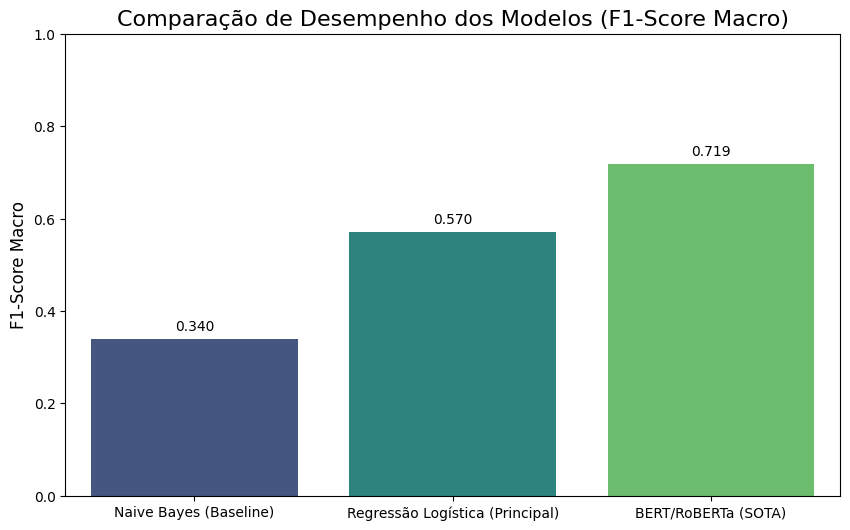

In [11]:
# Célula 12: Gráfico Comparativo - F1-Score Macro
import matplotlib.pyplot as plt
import seaborn as sns

modelos = ['Naive Bayes (Baseline)', 'Regressão Logística (Principal)', 'BERT/RoBERTa (SOTA)']
f1_macros = [0.34, 0.57, resultados_epoca_2['eval_f1_macro']]

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=modelos, y=f1_macros, palette='viridis')

plt.title('Comparação de Desempenho dos Modelos (F1-Score Macro)', fontsize=16)
plt.ylabel('F1-Score Macro', fontsize=12)
plt.ylim(0, 1.0)

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.3f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points')

plt.show()

Gerando predições do modelo BERT (Época 2) para a Matriz de Confusão...


Matriz de Confusão - BERT/RoBERTa (Principal)


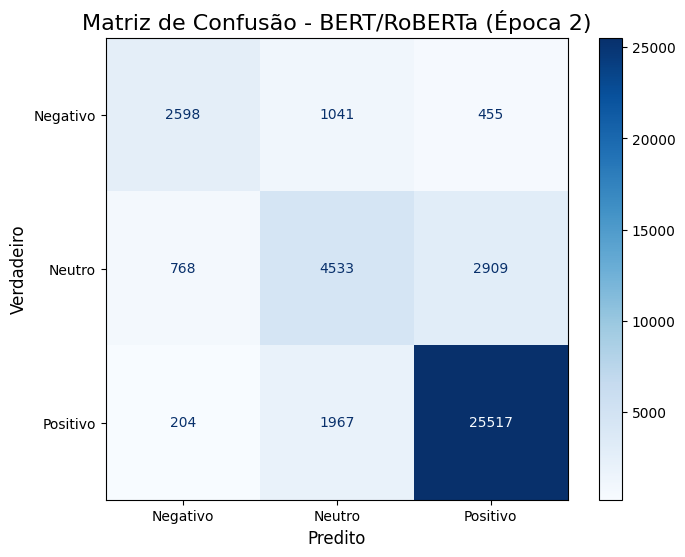

In [12]:
# Célula 13: Gerar Matriz de Confusão do BERT (Época 2)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Gerando predições do modelo BERT (Época 2) para a Matriz de Confusão...")

predicoes = trainer_epoca_2.predict(tokenized_test_dataset)

y_pred_bert = np.argmax(predicoes.predictions, axis=1)

y_true_bert = predicoes.label_ids

labels_nomes = ['Negativo', 'Neutro', 'Positivo']

cm_bert = confusion_matrix(y_true_bert, y_pred_bert, labels=[0, 1, 2])

print("Matriz de Confusão - BERT/RoBERTa (Principal)")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=labels_nomes)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - BERT/RoBERTa (Época 2)', fontsize=16)
plt.xlabel('Predito', fontsize=12)
plt.ylabel('Verdadeiro', fontsize=12)
plt.show()

Gerando Relatório de Classificação do BERT (Época 2)...
Relatório como DataFrame:


,precision,recall,f1-score,support
Negativo,0.73,0.63,0.68,4094
Neutro,0.60,0.55,0.58,8210
Positivo,0.88,0.92,0.90,27688
accuracy,NaN,NaN,NaN,0
macro avg,0.74,0.70,0.72,39992
weighted avg,0.81,0.82,0.81,39992



Imagem do relatório salva como 'bert_classification_report.png'


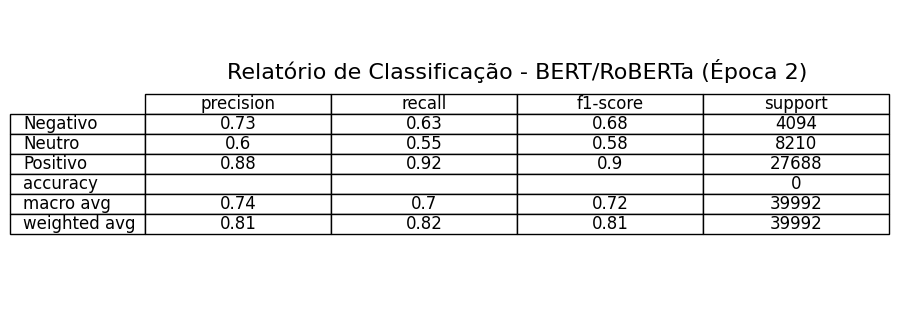

In [14]:
# Célula 14: Gerar Imagem do Relatório de Classificação (BERT)
from transformers import pipeline
import shutil
from sklearn.metrics import classification_report

print("Gerando Relatório de Classificação do BERT (Época 2)...")

report = classification_report(
    y_true_bert,
    y_pred_bert,
    target_names=labels_nomes,
    output_dict=True
)

report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(2)

report_df.loc['accuracy', 'support'] = report_df.loc['accuracy', 'f1-score']
report_df.loc['accuracy', ['precision', 'recall', 'f1-score']] = np.nan

report_df['support'] = report_df['support'].astype(int)

print("Relatório como DataFrame:")
display(report_df)

fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
ax.axis('tight')

plot_df = report_df.round(2).fillna('')

table = ax.table(
    cellText=plot_df.values,
    colLabels=plot_df.columns,
    rowLabels=plot_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.title('Relatório de Classificação - BERT/RoBERTa (Época 2)', fontsize=16, y=0.75)

plt.savefig('bert_classification_report.png', bbox_inches='tight', dpi=150)
print("\nImagem do relatório salva como 'bert_classification_report.png'")

plt.show()

### 4. Demonstração do Modelo (Inferência)

Esta célula demonstra o "print de recomendação" — como o modelo final classifica novas reviews.

In [15]:
# Célula 15: Pipeline de Demonstração

print("Carregando pipeline de análise de sentimento com o *melhor* modelo (Época 2)...")

id2label = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model_epoca_2,
    tokenizer=tokenizer,
    device=0
)

sentiment_pipeline.model.config.id2label = id2label


print("\n--- TESTANDO O MODELO --- (Inferência em reviews novas)")

# --- Teste 1: Review Positiva ---
review_positiva = "This is the best book I have ever read. The story was incredible and the characters were perfect. I loved it!"
resultado_pos = sentiment_pipeline(review_positiva)
print(f"Review: '{review_positiva}'")
print(f"Predição do Modelo: {resultado_pos}")


# --- Teste 2: Review Negativa ---
review_negativa = "I hated this book. It was boring, the plot made no sense, and the ending was terrible. A complete waste of time."
resultado_neg = sentiment_pipeline(review_negativa)
print(f"\nReview: '{review_negativa}'")
print(f"Predição do Modelo: {resultado_neg}")


# --- Teste 3: Review Neutra/Ambígua ---
review_neutra = "The book was okay. The beginning was slow, but it got better near the end. I'm not sure if I would recommend it."
resultado_neu = sentiment_pipeline(review_neutra)
print(f"\nReview: '{review_neutra}'")
print(f"Predição do Modelo: {resultado_neu}")

Device set to use cuda:0


Carregando pipeline de análise de sentimento com o *melhor* modelo (Época 2)...

--- TESTANDO O MODELO --- (Inferência em reviews novas)
Review: 'This is the best book I have ever read. The story was incredible and the characters were perfect. I loved it!'
Predição do Modelo: [{'label': 'Positivo', 'score': 0.9975143671035767}]

Review: 'I hated this book. It was boring, the plot made no sense, and the ending was terrible. A complete waste of time.'
Predição do Modelo: [{'label': 'Negativo', 'score': 0.9732068181037903}]

Review: 'The book was okay. The beginning was slow, but it got better near the end. I'm not sure if I would recommend it.'
Predição do Modelo: [{'label': 'Neutro', 'score': 0.7250043749809265}]
